In [7]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(".."))

from constants import ID2LABEL_KOR, ID2LABEL_EN # 1.constants 확인

LABEL2ID_EN = {v: k for k, v in ID2LABEL_EN.items()}

print(ID2LABEL_EN)
print(LABEL2ID_EN)

origin_file = './origin/감정 분류를 위한 대화 음성 데이터셋/5차년도.csv' # 2.origin file 확인
preprocessed_file_name = 'DVforEC(5_6l)' # 3.preprocessed file 확인


pp_file_name = f'./preprocess/{preprocessed_file_name}_pp.csv'
train_file_name = f'./preprocess/{preprocessed_file_name}_train.csv'
test_file_name = f'./preprocess/{preprocessed_file_name}_test.csv'
val_file_name = f'./preprocess/{preprocessed_file_name}_val.csv'

print(pp_file_name)

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise'}
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happiness': 3, 'Sadness': 4, 'Surprise': 5}
./preprocess/DVforEC(5_6l)_pp.csv


## preprocessing

In [19]:
import pandas as pd

df = pd.read_csv(origin_file, encoding='cp949')
print(len(df))
# #EDC
# df['label'] = df['감정_대분류'].map(LABEL2ID_EN)
# df['document'] = df['사람문장1']

# DVforEC5()
df['label'] = df['1번 감정'].map(LABEL2ID_EN)
df['document'] = df['발화문']
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(str)
print('after drop : ', len(df))
print(type(df['label'].iloc[0])
)
# #DVforEC(4_8l)
# df['label'] = df['1번 감정'].map(LABEL2ID_EN)
# df['document'] = df['발화문']

# csv 파일로 저장
df[['label', 'document']].to_csv(pp_file_name, index=False, encoding='utf-8-sig')


10011
after drop :  7513
<class 'str'>


### count_item

In [20]:
import pandas as pd

def count_items(file_name, column_name):
    df = pd.read_csv(file_name)
    print('total :', len(df))
    item_counts = df[column_name].value_counts()
    return item_counts

print(count_items(pp_file_name,'label'))

total : 7513
label
4.0    3998
1.0    1212
2.0    1114
0.0    1012
3.0     121
5.0      56
Name: count, dtype: int64


### count_items_visualization

total : 10011


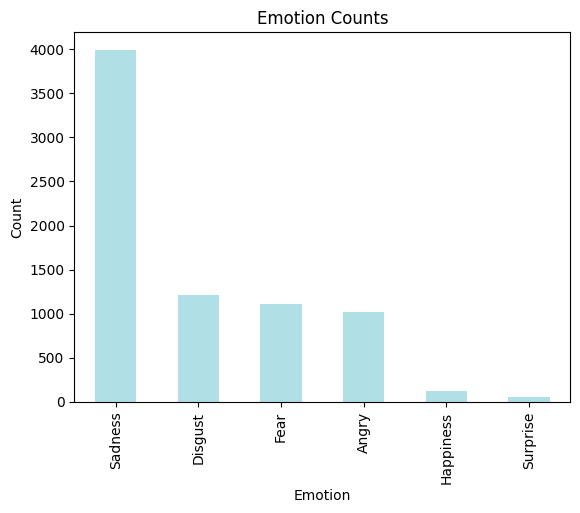

None


In [4]:
import pandas as pd
import matplotlib.pyplot as plt


emotion_map = ID2LABEL_EN

def count_items_visualization(file_name, column_name):

    counts = count_items(file_name, column_name)
    counts.index = counts.index.map(emotion_map)

    # 시각화 (막대 그래프)
    counts.plot(kind='bar', color='powderblue')
    
    plt.title('Emotion Counts')
    plt.xlabel('Emotion')
    plt.ylabel('Count')

    plt.show()

print(count_items_visualization(pp_file_name,'label'))


### onehot encoding

In [5]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(".."))

from constants import ID2LABEL_KOR, ID2LABEL_EN

# CSV 파일 읽기
df = pd.read_csv(pp_file_name)

# 각 레이블에 따라 0 또는 1을 가진 열 추가
for label_id, label_name in ID2LABEL_EN.items():
    df[label_name] = (df['label'] == label_id).astype(int)

df.to_csv(pp_file_name, index=False, encoding='utf-8-sig')

print(ID2LABEL_EN)
print("complete onehot encoding")

{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise'}
complete onehot encoding


## train, test, val 데이터셋 구성
test(테스트), val(검증)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 원본 데이터셋 로드
data_path = pp_file_name  # 원본 CSV 파일 경로를 지정하세요.
data = pd.read_csv(data_path)

# 데이터셋을 train (70%), val (15%), test (15%)로 나누기
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)  # 70% 훈련용 데이터
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)  # 나머지 30%에서 50%씩 나누기

# 데이터셋을 각각의 CSV 파일로 저장
train_data.to_csv(train_file_name, index=False, encoding='utf-8-sig')
val_data.to_csv(val_file_name, index=False, encoding='utf-8-sig')
test_data.to_csv(test_file_name, index=False, encoding='utf-8-sig')

print("Train, Validation, and Test datasets have been created and saved.")


Train, Validation, and Test datasets have been created and saved.
